## Restricted Boltzmann machine

In [0]:
%%capture
!pip install numpy sklearn matplotlib keras
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

In [0]:
# Loading the MNIST dataset 
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()
X_train = np.reshape(x_train, [-1, 784])
X_test = np.reshape(x_test, [-1, 784])
# To binary conversion:
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)
X_test = (X_test - np.min(X_test, 0)) / (np.max(X_test, 0) + 0.0001)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# Sigmoid function definition
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# upwards pass p(h|v) with included sampling 
# Function returns probabilities and a sample
def phv(v,W,h_bias):
  batch_size = v.shape[0]
  h_prob = sigmoid(np.dot(v,W.T)+h_bias)
  h_samp = h_prob>np.random.random((batch_size,h_bias.shape[0]))
  return h_prob,h_samp

# downward pass p(v|h) with included sampling 
# Function returns probabilities and a sample
def pvh(h,W,v_bias):
  batch_size = h.shape[0]
  v_prob = sigmoid(np.dot(h,W)+v_bias)
  v_samp = v_prob>np.random.random((batch_size,v_bias.shape[0]))
  return v_prob,v_samp

In [0]:
# gibbs sampling step, paremeterized by number of steps k
def gibbsSample(v,k,W,h_bias,v_bias):
  n_hidden = h_bias.shape[0]
  n_visible = v_bias.shape[0]
  vtilde_samp = v
  batch_size = v.shape[0]
  for i in range(k):
    h_prob,h_samp = phv(vtilde_samp,W,h_bias)
    vtilde_prob,vtilde_samp = pvh(h_samp,W,v_bias)
  return h_prob,h_samp,vtilde_prob,vtilde_samp
  
  

In [0]:
# Actual training process with included unit initialization
def train(data,n_hidden,learning_rate,iterations,batch_size):
  #Initialization
  n_hidden=n_hidden
  n_visible = data[0].shape[0]
  W = np.random.random((n_hidden,n_visible))
  h_bias = np.random.random(n_hidden)
  v_bias = np.random.random(n_visible)
  alpha = learning_rate
  batch_size = batch_size
  
  #Training
  for j in range(iterations):
    for i in range(0,data.shape[0],batch_size):
      batch = data[i:i+batch_size]
      
      # Compute batches of probability vectors and samples 
      # All values needed for a CD step are generated in the following two lines
      h_prob,h_samp,vtilde_prob,vtilde_samp = gibbsSample(batch,1,W,h_bias,v_bias)
      htilde_prob, htilde_samp = phv(vtilde_samp,W,h_bias,v_bias)
      
      
      # Numpy can only mean all vectors of same length, therefore group by length and then mean
      # This mean represents the Expectation 
      h_prob,h_samp,htilde_prob,htilde_samp = np.mean([h_prob,h_samp,htilde_prob,htilde_samp],axis=1)
      vtilde_prob,vtilde_samp = np.mean([vtilde_prob,vtilde_samp],axis=1)
      v_orig = np.mean(batch,axis=0)
      
      # Parameter updates using expectation values
      W += alpha*(np.outer(h_samp,np.transpose(v_orig)) - np.outer(htilde_samp,np.transpose(vtilde_samp)))
      h_bias += alpha*(h_samp-htilde_samp)
      v_bias += alpha*(v_orig-vtilde_samp)
    print('Iteration: ',j+1, ' done')  
  return W, h_bias, v_bias

In [0]:
W,h_bias,v_bias = train(X_train,1000,0.01,20,20)

Iteration:  1  done
Iteration:  2  done
Iteration:  3  done
Iteration:  4  done
Iteration:  5  done
Iteration:  6  done
Iteration:  7  done
Iteration:  8  done
Iteration:  9  done
Iteration:  10  done
Iteration:  11  done
Iteration:  12  done
Iteration:  13  done
Iteration:  14  done
Iteration:  15  done
Iteration:  16  done
Iteration:  17  done
Iteration:  18  done
Iteration:  19  done
Iteration:  20  done


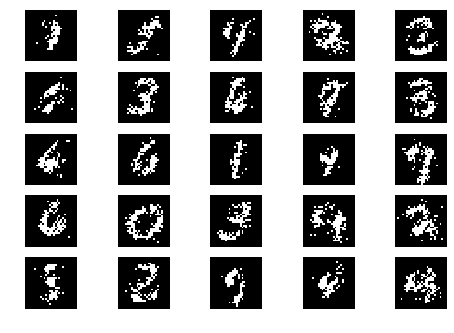

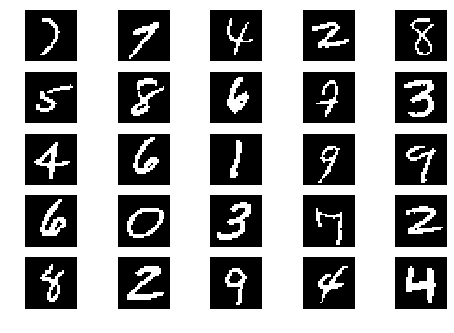

In [0]:
# Plotting functions to generate a grid with 25 samples
def rbmPlot(data,gibbs_steps,W,h_bias,v_bias):
  rows = 5
  cols = 5
  images = np.zeros((rows*cols,784))
    
  
  _,_,_,images[0:rows*cols,:] = gibbsSample(data[0:25],gibbs_steps,W,h_bias,v_bias)
    
  images = images.reshape(rows*cols,28,28)
  
  fig, axs = plt.subplots(rows, cols)
  cnt = 0
  for i in range(rows):
      for j in range(cols):
          axs[i,j].imshow(images[cnt, :,:], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  plt.show()

def plotMnist(data,r,c):
  fig, axs = plt.subplots(r, c)
  images = data[0:r*c].reshape(r*c,28,28)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(images[cnt, :,:], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  plt.show()

rbmPlot(X_train[140:],5,W,h_bias,v_bias)
plotMnist(X_train[140:],5,5)

# Deep Belief Network

In [0]:
# Load MNIST dataset
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = np.reshape(x_train, [-1, 784])
X_test = np.reshape(x_test, [-1, 784])
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [0]:
#binary conversion
X_train = np.rint(X_train)
X_test = np.rint(X_test)

In [0]:
# Use scikit learns BernoulliRBM as baseline RBM because its faster
from sklearn.neural_network import BernoulliRBM

# define hidden layer sizes
units = [500,500,1000]

#Define the rbms (this could be done in a loop easily)
first = BernoulliRBM(n_components = units[0],learning_rate=0.01,verbose=1,n_iter=20,batch_size=20)
print("training first RBM:")

# fit_transform trains the RBM and also 
# transforms the input to probabilities which we can use to pass samples up
data_h1 = first.fit_transform(X_train) 
data_h1_samples = data_h1>np.random.random(size=data_h1.shape)

# If we want to guarantee an improvement, use W.T as initialization in the new rbm, also need to put second n_compoennts to 784
second = BernoulliRBM(n_components = units[1],learning_rate=0.01,verbose=1,n_iter=20,batch_size=20)
print("training second RBM:")
data_h2 = second.fit_transform(data_h1_samples)
data_h2_samples = data_h2>np.random.random(size=data_h2.shape)

third = BernoulliRBM(n_components = units[2],learning_rate=0.01,verbose=1,n_iter=20,batch_size=20)
print("training third RBM:")
third.fit(data_h2_samples)

training first RBM:
[BernoulliRBM] Iteration 1, pseudo-likelihood = -106.26, time = 42.83s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -90.61, time = 49.73s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -81.09, time = 49.04s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -75.34, time = 50.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -71.87, time = 49.54s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -70.62, time = 49.21s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -69.23, time = 49.18s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -69.57, time = 48.74s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -65.82, time = 49.45s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -65.70, time = 49.17s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -64.37, time = 48.63s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -62.73, time = 49.71s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -64.63, time = 49.39s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -65.63, time = 4

BernoulliRBM(batch_size=20, learning_rate=0.01, n_components=1000, n_iter=20,
       random_state=None, verbose=1)

In [0]:
# Combine the rbms into a list
rbmList = [first,second,third]

In [0]:
# Define sigmoid again in case user did not execute RBM code
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# define downwards pass for sampling procedure
def downPass(h,rbm):
  w = rbm.components_
  v_bias = rbm.intercept_visible_
  v_bias = v_bias
  prod = np.dot(h,w)
  return sigmoid(prod+v_bias)

# define upwards pass for sampling procedure
def upPass(v,rbm):
  w = rbm.components_
  h_bias = rbm.intercept_hidden_
  prod = np.dot(v,w.T)
  return sigmoid(prod+h_bias)

# Combine passes into complete sampling procedure
def generateSample(sample,rbmList,n_gibbs):
  
  # upwards pass
  for i in rbmList[:-1]:
    
    sample = upPass(sample,i)
    sample = sample > np.random.random(sample.shape)
    
  # gibbs sampling in top layer
  for i in range(n_gibbs):
    
    sample = sample.reshape(sample.shape[0])
    sample = rbmList[-1].gibbs(sample)
  
  # downwards pass.  
  for i in reversed(rbmList[:-1]):
    sample = downPass(sample,i)
    sample = sample > np.random.random(sample.shape)
  
  return sample
    

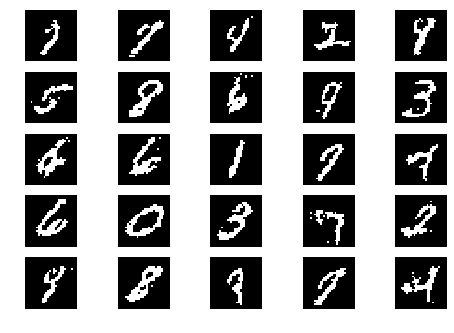

In [0]:
import matplotlib.pyplot as plt

# Plot 5x5 sample grid
def dbnPlot(data,gibbs_steps,rbmList):
  rows = 5
  cols = 5
  images = np.zeros((rows*cols,784))
    
  for i in range(rows*cols):
    images[i,:] = generateSample(data[i],rbmList,gibbs_steps)
    
  images = images.reshape(rows*cols,28,28)
  
  fig, axs = plt.subplots(rows, cols)
  cnt = 0
  for i in range(rows):
      for j in range(cols):
          axs[i,j].imshow(images[cnt, :,:], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  plt.show()

dbnPlot(X_train[140:],5,rbmList)

# VAE

In [0]:
# Load MNIST but this time not binary 
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()
X_train = np.reshape(x_train, [-1, 784])
X_test = np.reshape(x_test, [-1, 784])
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [0]:
# The VAE is written using the machine learning library Keras which allows for
# relatively easy construction of neural networks
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as k
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy

# parameter definition
batch_size = 128
hid_dim = 512

k.clear_session()

# Generate a sample using reparametrization trick
def sample(args):
  mean,sigma = args
  batch = k.shape(mean)[0]
  dim = k.int_shape(mean)[1]
  epsilon = k.random_normal(shape=(batch,dim))
  return mean+k.exp(sigma)*epsilon



# Defining the encoder network
inp = Input(shape=(784,))
hid = Dense(hid_dim,activation='relu')(inp)
z_mean = Dense(2)(hid)
z_log_sigma = Dense(2)(hid)
z = Lambda(sample,output_shape=(2,))([z_mean,z_log_sigma])

encoder = Model(inp,[z_mean,z_log_sigma,z])

# Decoder
# The decoder is skipping to model another distribution with reparametrization.
# We can only do this because probabilities are in [0,1] and the samples are in [0,1] as well
latent_input = Input(shape=(2,))
dec_hid = Dense(hid_dim, activation='relu')(latent_input)
dec_out = Dense(784, activation='sigmoid')(dec_hid)

decoder = Model(latent_input,dec_out)

dec_out = decoder(encoder(inp)[2])


# Model
vae = Model(inp,dec_out)

# Define loss of the model
def combinedLoss(x,y):
  reconstruction_loss = binary_crossentropy(x,y)
  reconstruction_loss *= 784
  kl_loss = -0.5*k.sum(1 + z_log_sigma - k.square(z_mean) - k.exp(z_log_sigma), axis=-1)
  vae_loss = k.mean(reconstruction_loss + kl_loss)
  return vae_loss

  
vae.compile(optimizer='adam',loss=combinedLoss)
vae.fit(X_train,X_train,epochs=50,batch_size=batch_size,validation_data=(X_test,X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 22s 361us/step - loss: 203.1309 - val_loss: 177.2190
Epoch 2/50
60000/60000 [==============================] - 21s 351us/step - loss: 172.0314 - val_loss: 167.3122
Epoch 3/50
60000/60000 [==============================] - 21s 356us/step - loss: 166.0450 - val_loss: 164.0684
Epoch 4/50
60000/60000 [==============================] - 21s 354us/step - loss: 163.6461 - val_loss: 162.1786
Epoch 5/50
60000/60000 [==============================] - 21s 356us/step - loss: 161.9234 - val_loss: 161.3199
Epoch 6/50
60000/60000 [==============================] - 21s 354us/step - loss: 160.6062 - val_loss: 159.7656
Epoch 7/50
60000/60000 [==============================] - 22s 359us/step - loss: 159.4764 - val_loss: 159.1280
Epoch 8/50
60000/60000 [==============================] - 22s 368us/step - loss: 158.4068 - val_loss: 157.8721
Epoch 9/50
60000/60000 [==============================] - 22s 

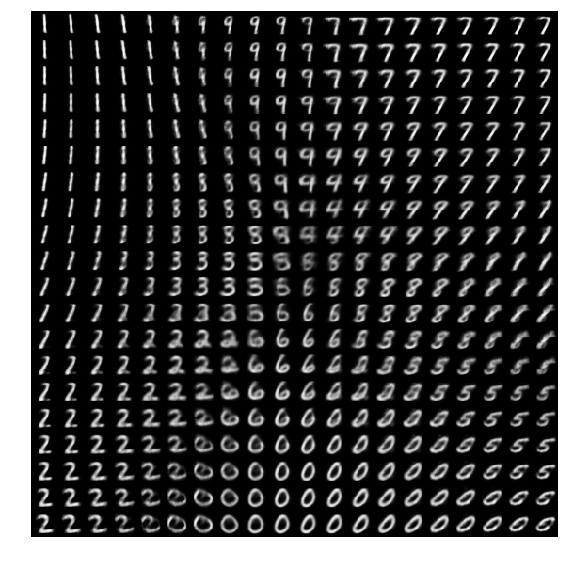

In [0]:
# Function for creating a gridplot over latent space
def vaeGridPlot(decoder):
  rows = 20
  cols = 20
  figure = np.zeros((28*rows,28*cols))
  x = np.linspace(-2,2,cols)
  y = np.linspace(-2,2,rows)
  
  for i, yi in enumerate(x):
    for j, xi in enumerate(y):
      img = decoder.predict(np.array([[xi,yi]]))
      img = img.reshape(28,28)
      figure[(rows-i-1)*28:(rows-i)*28,j*28:(j+1)*28] = img
        

  plt.figure(figsize=(8, 10))        
  Xi, Yi = np.meshgrid(x, y)
  plt.imshow(figure, origin="upper", cmap="gray")
  plt.tight_layout()
  plt.axis('off')
  plt.show()
  
  
vaeGridPlot(decoder)

# GAN

In [0]:
# Mnist but using values from -1 to 1
from keras.datasets import mnist
import numpy as np
(x_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(x_train, [-1, 784])
X_train = X_train / 127.5 -1

In [0]:
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

# Define dimensions of network
img_shape = X_train[0].shape[0]
noise_size = 100
gen_neurons = [256,512,1024]
disc_neurons = [512,256]

# define generator
# Required Batch Normalization to get to good generation faster
gen_inp = Input(shape=(noise_size,))

gen_hid_1 = Dense(gen_neurons[0])(gen_inp)
gen_act_1 = LeakyReLU(alpha=0.2)(gen_hid_1)
gen_norm_1 = BatchNormalization(momentum=0.8)(gen_act_1)

gen_hid_2 = Dense(gen_neurons[0])(gen_norm_1)
gen_act_2 = LeakyReLU(alpha=0.2)(gen_hid_2)
gen_norm_2 = BatchNormalization(momentum=0.8)(gen_act_2)

gen_hid_3 = Dense(gen_neurons[0])(gen_norm_2)
gen_act_3 = LeakyReLU(alpha=0.2)(gen_hid_3)
gen_norm_3 = BatchNormalization(momentum=0.8)(gen_act_3)

gen_hid_out = Dense(img_shape,activation='tanh')(gen_norm_3)


#define discriminator
disc_inp = Input(shape=(img_shape,))
disc_hid_1 = Dense(disc_neurons[0])(disc_inp)
disc_act_1 = LeakyReLU(alpha=0.2)(disc_hid_1)
disc_hid_2 = Dense(disc_neurons[1])(disc_act_1)
disc_act_2 = LeakyReLU(alpha=0.2)(disc_hid_2)
disc_hid_out = Dense(1,activation='sigmoid')(disc_act_2)

gen = Model(gen_inp,gen_hid_out)
disc = Model(disc_inp,disc_hid_out)

adam = Adam(0.0002,0.5)

disc.trainable = True
disc.compile(loss='binary_crossentropy',optimizer =adam, metrics=['accuracy'])

# create combined model, where discriminator is not trainable:
noise_inp = Input(shape=(noise_size,))
gen_comb = gen(noise_inp)
disc.trainable = False
disc_comb = disc(gen_comb)

combined = Model(noise_inp,disc_comb)
combined.compile(loss='binary_crossentropy',optimizer =adam)

# Set training parameters
batch_size = 32
iterations = 30000
disc_iterations = 1
gen_iterations = 1

target_real = np.ones((batch_size,1))
target_fake = np.zeros((batch_size,1))

# Noise generator function
def gen_noise(batch_size,noise_size):
  return np.random.normal(0,1,(batch_size,noise_size))


# Training loop
for i in range(iterations):
  # discriminator loop
  for j in range(disc_iterations):
    # generate noise
    noise = gen_noise(batch_size,noise_size)
    # create batches
    batch_fake = gen.predict(noise)
    batch_real = X_train[np.random.randint(0,X_train.shape[0],batch_size)]
    # losses
    ld1 = disc.train_on_batch(batch_real,target_real)
    ld2 = disc.train_on_batch(batch_fake,target_fake)
  # generator loop
  for k in range(gen_iterations):
    noise = gen_noise(batch_size,noise_size)
    lg = combined.train_on_batch(noise,target_real)
  if(i%(iterations/100)==0):
    print("Iteration: ",i,"Discriminator fake loss:",ld2[0]," Discriminator Accuracy: ",(ld1+ld2)[1]*0.5," Generator loss: ",lg)



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iteration:  0 Discriminator fake loss: 0.7666724  Discriminator Accuracy:  0.40625  Generator loss:  0.6976719
Iteration:  300 Discriminator fake loss: 0.66715884  Discriminator Accuracy:  0.484375  Generator loss:  1.2042909
Iteration:  600 Discriminator fake loss: 0.6287675  Discriminator Accuracy:  0.46875  Generator loss:  1.0670452
Iteration:  900 Discriminator fake loss: 0.51408136  Discriminator Accuracy:  0.484375  Generator loss:  1.3122549
Iteration:  1200 Discriminator fake loss: 0.41992867  Discriminator Accuracy:  0.34375  Generator loss:  1.3703179
Iteration:  1500 Discriminator fake loss: 0.4383561  Discriminator Accuracy:  0.375  Generator loss:  1.5176891
Iteration:  1800 Discriminator fake loss: 0.40022355  Discriminator Accuracy:  0.375  Generator loss:  1.4574116
Iteration:  2100 Discriminator fake loss: 0.3232437  Discriminator Accuracy:  0.390625  Generator loss:  1.7631327
Iteration:  2400 Discriminator fake loss: 0.35931203  Discriminator Accuracy:  0.359375  Ge

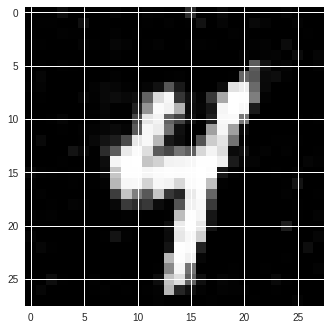

In [0]:
sample_noise = gen_noise(1,noise_size)
res = gen.predict(sample_noise)

res = res.reshape(28,28)
plt.imshow(res, cmap='Greys_r',  interpolation='nearest')
plt.show()

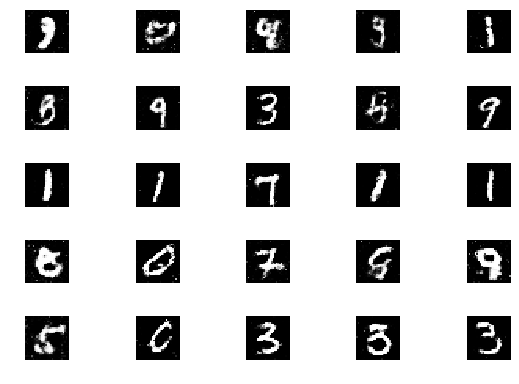

In [0]:
# 5x5 grid GAN samples generator
def ganMultiImage(generator,noise_size):
  rows = 5
  cols = 5
  sample_noise = gen_noise(rows*cols,noise_size)
  images = generator.predict(sample_noise)
  images = images.reshape(rows*cols,28,28)
  
  fig, axs = plt.subplots(rows, cols)
  cnt = 0
  for i in range(rows):
      for j in range(cols):
          axs[i,j].imshow(images[cnt, :,:], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  plt.tight_layout()
  plt.show()
  
ganMultiImage(gen,noise_size)